### This notebook generates the moisture-precip relationships for MCSs in the idealized RCE simulations.

In [1]:
import numpy as np
import scipy as sp
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import warnings, random
from matplotlib import cm
import scipy.optimize

from scipy.optimize import curve_fit

plt.rcParams.update({'font.size': 12})

warnings.filterwarnings(action='ignore')

from plotting_utilities import *
from thermodynamic_functions import *

# colorblind friendly colormap

CB_color_cycle = [ '#377eb8', '#ff7f00', '#4daf4a', '#f781bf', '#a65628', '#984ea3',
                   '#999999', '#e41a1c', '#dede00']

## Loading RCE data

In [2]:
path = '/groups/sylvia/JAS-MCS-rain/RCE-postprocessed/'
ssts = np.arange( 280, 315, 5 )

mean_280 = xr.open_dataset( path + 'RCE_COL_MEAN_280.nc' )
mean_285 = xr.open_dataset( path + 'RCE_COL_MEAN_285.nc' )
mean_290 = xr.open_dataset( path + 'RCE_COL_MEAN_290.nc' )
mean_295 = xr.open_dataset( path + 'RCE_COL_MEAN_295.nc' )
mean_300 = xr.open_dataset( path + 'RCE_COL_MEAN_300.nc' )
mean_305 = xr.open_dataset( path + 'RCE_COL_MEAN_305.nc' )
mean_310 = xr.open_dataset( path + 'RCE_COL_MEAN_310.nc' )

max_280 = xr.open_dataset( path + 'RCE_COL_MAX_280.nc' )
max_285 = xr.open_dataset( path + 'RCE_COL_MAX_285.nc' )
max_290 = xr.open_dataset( path + 'RCE_COL_MAX_290.nc' )
max_295 = xr.open_dataset( path + 'RCE_COL_MAX_295.nc' )
max_300 = xr.open_dataset( path + 'RCE_COL_MAX_300.nc' )
max_305 = xr.open_dataset( path + 'RCE_COL_MAX_305.nc' )
max_310 = xr.open_dataset( path + 'RCE_COL_MAX_310.nc' )

p95_280 = xr.open_dataset( path + 'RCE_COL_95_280.nc' )
p95_285 = xr.open_dataset( path + 'RCE_COL_95_285.nc' )
p95_290 = xr.open_dataset( path + 'RCE_COL_95_290.nc' )
p95_295 = xr.open_dataset( path + 'RCE_COL_95_295.nc' )
p95_300 = xr.open_dataset( path + 'RCE_COL_95_300.nc' )
p95_305 = xr.open_dataset( path + 'RCE_COL_95_305.nc' )
p95_310 = xr.open_dataset( path + 'RCE_COL_95_310.nc' )

p99_280 = xr.open_dataset( path + 'RCE_COL_99_280.nc' )
p99_285 = xr.open_dataset( path + 'RCE_COL_99_285.nc' )
p99_290 = xr.open_dataset( path + 'RCE_COL_99_290.nc' )
p99_295 = xr.open_dataset( path + 'RCE_COL_99_295.nc' )
p99_300 = xr.open_dataset( path + 'RCE_COL_99_300.nc' )
p99_305 = xr.open_dataset( path + 'RCE_COL_99_305.nc' )
p99_310 = xr.open_dataset( path + 'RCE_COL_99_310.nc' )

In [3]:
means = [ mean_280, mean_285, mean_290, mean_295, mean_300, mean_305, mean_310 ]
maxes = [ max_280, max_285, max_290, max_295, max_300, max_305, max_310 ]
p95s = [ p95_280, p95_285, p95_290, p95_295, p95_300, p95_305, p95_310 ]
p99s = [ p99_280, p99_285, p99_290, p99_295, p99_300, p99_305, p99_310 ]

data_mean = xr.combine_nested( means, concat_dim='clusters' )
data_max = xr.combine_nested( maxes, concat_dim='clusters' )
data_p95 = xr.combine_nested( p95s, concat_dim='clusters' )
data_p99 = xr.combine_nested( p99s, concat_dim='clusters' )

In [4]:
display( mean_280 )
#display( data_mean )

<xarray.Dataset>
Dimensions:   (clusters: 710, z: 64)
Coordinates:
  * clusters  (clusters) float64 7.002e+04 7.009e+04 ... 7.968e+05 7.974e+05
  * z         (z) float32 37.0 112.0 194.0 ... 2.696e+04 2.746e+04 2.796e+04
Data variables:
    p_rate    (clusters) float64 ...
    CAPE      (clusters) float32 ...
    cwvc      (clusters) float32 ...
    csf       (clusters) float32 ...
    SD        (clusters) float32 ...
    omega     (clusters, z) float32 ...
    TABS      (clusters, z) float32 ...
    QV        (clusters, z) float32 ...
    p         (clusters, z) float32 ...

##  Binning of CSF and precipitation -- mean and max

In [5]:
sst = [ '295 K', '300 K', '305 K', '310 K' ]
mean_RCE = [ mean_295, mean_300, mean_305, mean_310 ]
max_RCE = [ max_295, max_300, max_305, max_310 ]

csf_bins_list = [ [] for i in np.arange( len(mean_RCE) ) ]
pmean_list = [ [] for i in np.arange( len(mean_RCE) ) ]
perror_list = [ [] for i in np.arange( len(mean_RCE) ) ]

csf_max_list = [ [] for i in np.arange( len(max_RCE) ) ]
pmax_list = [ [] for i in np.arange( len(max_RCE) ) ]

m_list = [ [] for i in np.arange( len(mean_RCE) ) ]
a_list = [ [] for i in np.arange( len(mean_RCE) ) ]
m_list2 = [ [] for i in np.arange( len(mean_RCE) ) ]
a_list2 = [ [] for i in np.arange( len(mean_RCE) ) ]

In [6]:
# exponential fit between CSF and precipitation
def monoexp(x, m, a):
    return m * np.exp(a * x)

In [1]:
for iterator, array in enumerate( max_RCE ):
    csf_RCE = array['csf'].to_numpy()
    pmean_RCE = array['p_rate'].to_numpy()

    csf_bins, pmean_vals, _, _, _, p_error, csf_max, pmax = \
        bin_stat_function( 50, 0.25, 1, csf_RCE, pmean_RCE, threshold=10 )
    
    csf_bins_list[iterator] = csf_bins
    csf_max_list[iterator] = csf_max
    pmean_list[iterator] = pmean_vals
    pmax_list[iterator] = pmax
    perror_list[iterator] = p_error
    
    # fit an exponential to the mean CSF-Precip relationship and assess goodness-of-fit
    # CSF input to the curve_fit is a decimal not a percentage, hence /100.
    p0 = [ 1, 11 ]
    i = np.where( ~np.isnan(csf_bins) )
    params, cv = scipy.optimize.curve_fit( monoexp, csf_bins[i]/100., pmean_vals[i], p0 )
    m, a = params
    m_list[iterator] = m
    a_list[iterator] = a
    
    squaredDiffs = np.square(pmean_vals[i] - monoexp(csf_bins[i]/100., m, a))
    squaredDiffsFromMean = np.square(pmean_vals[i] - np.mean(pmean_vals[i]))
    rSquared = 1 - np.sum(squaredDiffs) / np.sum(squaredDiffsFromMean)
    print( rSquared )
    print( str(m) + ' ' + str(a) )
    
    # fit an exponential to the max CSF-Precip relationship
    p0 = [ 1, 11 ]
    i = np.where( ~np.isnan(csf_max) )
    params, cv = scipy.optimize.curve_fit( monoexp, csf_max[i]/100., pmax[i], p0 )
    m, a = params
    m_list2[iterator] = m
    a_list2[iterator] = a
    print( str(m) + ' ' + str(a) )
    print( '~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~' )

NameError: name 'max_RCE' is not defined

In [2]:
fig, ax = plt.subplots( 1, 2, figsize =(11, 4.5) )

ylab = [ r'Mean $\dot{P}$ [mm h$^{-1}$]', r'Max $\dot{P}$ [mm h$^{-1}$]' ]
xlab = [ 'Column Saturation Fraction [%]', 'Column Saturation Fraction [%]' ]
font_size = 18
plt.rcParams.update({
    'font.size':font_size,
    'axes.labelsize':font_size+2,
    'xtick.labelsize':font_size,
    'ytick.labelsize':font_size,
    'legend.fontsize':font_size,
})

for i, axis in enumerate(ax): 
    axis.set( ylabel = ylab[i] )
    #axis.set_xlim( [0, 100] )
    axis.spines['top'].set_visible( False )
    axis.spines['right'].set_visible( False )
    axis.set( xlabel = xlab[i] )
    for t in axis.get_yticklabels():
        t.set_rotation(45)
    
    if i == 0:
        for j, k, l, m, n, o in zip(csf_bins_list, pmean_list, np.arange(len(csf_bins_list)), perror_list, m_list, a_list):
            y = monoexp( j/100, n, o )
            axis.plot( j, y, lw=3, color=CB_color_cycle[l], zorder=0 )
            axis.scatter( j, k, color = CB_color_cycle[l], s=80, edgecolor='black', label=sst[l]  )
            axis.errorbar( j, k, xerr=None, yerr=m/2, color = CB_color_cycle[l], ls='none' )
        handles, labels = axis.get_legend_handles_labels()
        order = [0,1,2,3]
        axis.legend( [handles[idx] for idx in order], [labels[idx] for idx in order], frameon=False )
    else:
        for j, k, l, o, p in zip(csf_bins_list, pmax_list, np.arange(len(csf_bins_list)), m_list2, a_list2):
            y = monoexp( j/100, o, p )
            axis.plot( j, y, lw=3, color=CB_color_cycle[l], zorder=1 )
            for m, n in zip(j, k):
                if ~np.isnan(m):
                    axis.scatter( [m]*len(n), n, color = CB_color_cycle[l], s=30, edgecolor='black', zorder=0 )
            
plt.tight_layout()
fig.savefig( '/groups/sylvia/JAS-MCS-rain/figures/csf-precip-RCE-AMS-poster.pdf', bbox_inches='tight' )
plt.show()

NameError: name 'plt' is not defined

##  Binning of saturation deficit and CAPE -- mean and max 

In [9]:
mean_RCE = [ mean_295, mean_300, mean_305, mean_310 ]
max_RCE = [ max_295, max_300, max_305, max_310 ]

sd_bins_list = [ [] for i in np.arange( len(mean_RCE) ) ]
capemean_list = [ [] for i in np.arange( len(mean_RCE) ) ]
capeerror_list = [ [] for i in np.arange( len(mean_RCE) ) ]

sd_max_list = [ [] for i in np.arange( len(max_RCE) ) ]
capemax_list = [ [] for i in np.arange( len(max_RCE) ) ]

In [227]:
print(mean_295['SD'].max(),mean_295['SD'].min())

<xarray.DataArray 'SD' ()>
array(2.99421144) <xarray.DataArray 'SD' ()>
array(0.17387719)


In [30]:
for iterator, array, array2 in zip( np.arange(len(mean_RCE)), mean_RCE, max_RCE ):
    sd_RCE = array['SD'].to_numpy()
    capemean_RCE = array['CAPE'].to_numpy()

    sd_bins, capemean_vals, _, _, _, cape_error, sd_max, capemax = \
        bin_stat_function( 15, np.nanmin(sd_RCE), np.nanmax(sd_RCE), sd_RCE, capemean_RCE, threshold=50 )
    print( np.nanmin(sd_RCE), np.nanmax(sd_RCE) )
    #sd_bins, capemean_vals, _, _, _, cape_error, sd_max, capemax = \
    #    bin_stat_function( 50, 0, 4, sd_RCE, capemean_RCE, threshold=100 )
    
    sd_bins_list[iterator] = sd_bins
    capemean_list[iterator] = capemean_vals
    capemax_list[iterator] = capemax
    capeerror_list[iterator] = cape_error
    
    #sd_RCE = array2['SD'].to_numpy()
    #capemean_RCE = array2['CAPE'].to_numpy()
    #_, _, _, _, _, _, sd_max, capemax = \
    #    bin_stat_function( 15, np.nanmin(sd_RCE), np.nanmax(sd_RCE), sd_RCE, capemean_RCE, threshold=10 )
    sd_max_list[iterator] = sd_max
    capemax_list[iterator] = capemax

0.1738772 2.9942114
0.41260213 8.441118
1.0358447 11.895164
1.0569636 18.01028


In [31]:
def parab(x, a, b, c):
    return a * x**2 + b * x + c

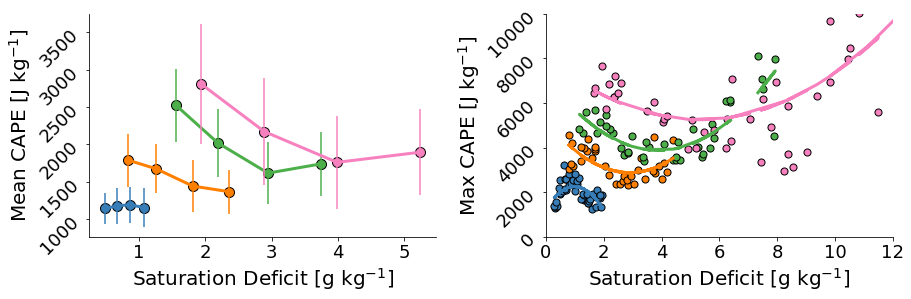

In [32]:
fig, ax = plt.subplots( 1, 2, figsize =(13, 4.5) )

ylab = [ r'Mean CAPE [J kg$^{-1}$]', r'Max CAPE [J kg$^{-1}$]' ]
labels = [ r'Saturation Deficit [g kg$^{-1}$]', r'Saturation Deficit [g kg$^{-1}$]' ]
font_size = 18
plt.rcParams.update({
    'font.size':font_size,
    'axes.labelsize':font_size+2,
    'xtick.labelsize':font_size,
    'ytick.labelsize':font_size,
    'legend.fontsize':font_size,
})

for i, axis in enumerate(ax): 
    axis.set( ylabel = ylab[i] )
    #axis.set_xlim( [0, 100] )
    axis.spines['top'].set_visible( False )
    axis.spines['right'].set_visible( False )
    axis.set( xlabel = labels[i] )
    for t in axis.get_yticklabels():
        t.set_rotation(45)
    
    if i == 0:
        for j, k, l, m in zip(sd_bins_list, capemean_list, np.arange(len(sd_bins_list)), capeerror_list):
            axis.scatter( j, k, color = CB_color_cycle[l], s=100, edgecolor='black'  )
            axis.plot( j, k, color = CB_color_cycle[l], linewidth=3 )
            axis.errorbar( j, k, xerr=None, yerr=m/2, color = CB_color_cycle[l], ls='none' )
    else:
        for j, k, l in zip(sd_max_list, capemax_list, np.arange(len(sd_bins_list))):
            j = j.flatten()
            k = k.flatten()
            axis.scatter( j, k, color = CB_color_cycle[l], s=50, edgecolor='black', label=sst[l]  )
            # Use curve_fit to fit the function to the data
            i = np.argwhere( ~np.isnan(j) )
            popt, _ = curve_fit(parab, j[i].flatten(), k[i].flatten())

            # Extract the fitted parameters
            a_fit, b_fit, c_fit = popt

            # Generate fitted curve
            k_fit = parab(j, a_fit, b_fit, c_fit)
            axis.plot( j, k_fit, color=CB_color_cycle[l], linewidth=3 )
        #axis.set_xscale('log')
        #axis.set_yscale('log')
        axis.set_ylim([0,10000])
        axis.set_xlim([0,12])
        handles, labels = axis.get_legend_handles_labels()
        order = [0,1,2,3]
        #axis.legend( [handles[idx] for idx in order], [labels[idx] for idx in order], frameon=False, bbox_to_anchor=(0,0,1.2,1))
            
plt.tight_layout()
fig.savefig( '/groups/sylvia/JAS-MCS-rain/figures/sd-cape-RCE-AMS-poster.pdf', bbox_inches='tight' )
plt.show()

##  Binning of CAPE and ascent rate -- mean and max 

In [134]:
mean_RCE = [ mean_295, mean_300, mean_305, mean_310 ]
max_RCE = [ max_295, max_300, max_305, max_310 ]

cape_bins_list = [ [] for i in np.arange( len(mean_RCE) ) ]
omegamean_list = [ [] for i in np.arange( len(mean_RCE) ) ]
omegaerror_list = [ [] for i in np.arange( len(mean_RCE) ) ]

cape_max_list = [ [] for i in np.arange( len(max_RCE) ) ]
omegamax_list = [ [] for i in np.arange( len(max_RCE) ) ]

In [135]:
# Verifying that 18 is the index closest to 500 hPa
for i in np.arange(10):
    n = random.randint( 0, mean_295['omega'].shape[1] )
    print( mean_295['p'][n,18].values )
    
print(mean_295['omega'].shape)
print(mean_295['omega'][:,18].max(),mean_295['omega'][:,18].min())
print(max_295['omega'][:,18].max(),max_295['omega'][:,18].min())

512.17694
511.83597
511.882
512.095
512.311
512.1317
512.1838
511.876
512.19226
512.04
(590, 64)
<xarray.DataArray 'omega' ()>
array(1.14443851)
Coordinates:
    z        float32 5.459e+03 <xarray.DataArray 'omega' ()>
array(-5.52506399)
Coordinates:
    z        float32 5.459e+03
<xarray.DataArray 'omega' ()>
array(165.86332703)
Coordinates:
    z        float32 5.459e+03 <xarray.DataArray 'omega' ()>
array(12.11566448)
Coordinates:
    z        float32 5.459e+03


In [137]:
for iterator, array in enumerate( mean_RCE ):
    cape_RCE = array['CAPE'].to_numpy()
    omegamean_RCE = array['omega'][:,18].to_numpy()  # omega at 500 hPa 
    
    # we want ascent rate - where omega < 0
    i = np.argwhere( omegamean_RCE < 0 )
    cape_RCE = cape_RCE[i]
    omegamean_RCE = np.abs( omegamean_RCE[i] )

    cape_bins, omegamean_vals, _, _, _, omega_error, cape_max, omegamax = \
        bin_stat_function( 15, 0, 6000, cape_RCE, omegamean_RCE, threshold=10 ) #20000 as upper bound for max_RCE
    
    cape_bins_list[iterator] = cape_bins
    cape_max_list[iterator] = cape_max
    omegamean_list[iterator] = omegamean_vals
    omegamax_list[iterator] = omegamax
    omegaerror_list[iterator] = omega_error

In [140]:
def linie(x, a, b):
    return a * x + b

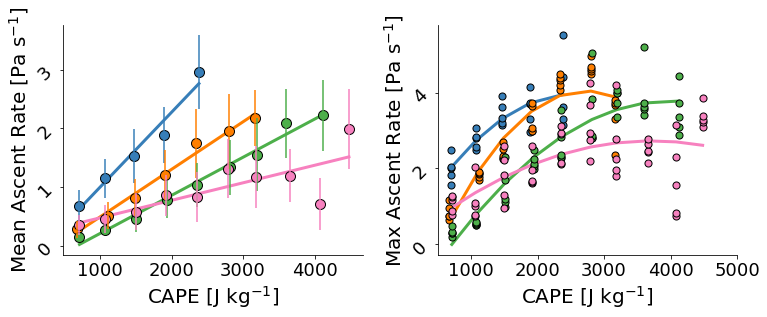

In [168]:
fig, ax = plt.subplots( 1, 2, figsize =(11, 4.5) )

ylab = [ r'Mean Ascent Rate [Pa s$^{-1}$]', r'Max Ascent Rate [Pa s$^{-1}$]' ]
labels = [ r'CAPE [J kg$^{-1}$]', 'CAPE [J kg$^{-1}$]' ]
font_size = 18
plt.rcParams.update({
    'font.size':font_size,
    'axes.labelsize':font_size+2,
    'xtick.labelsize':font_size,
    'ytick.labelsize':font_size,
    'legend.fontsize':font_size,
})

for i, axis in enumerate(ax): 
    axis.set( ylabel = ylab[i] )
    #axis.set_xlim( [0, 100] )
    axis.spines['top'].set_visible( False )
    axis.spines['right'].set_visible( False )
    axis.set( xlabel = labels[i] )
    for t in axis.get_yticklabels():
        t.set_rotation(45)
    
    if i == 0:
        for j, k, l, m in zip(cape_bins_list, omegamean_list, np.arange(len(cape_bins_list)), omegaerror_list):
            axis.scatter( j, k, color = CB_color_cycle[l], s=100, edgecolor='black'  )
            # Use curve_fit to fit the function to the data
            i = np.argwhere( ~np.isnan(j) )
            popt, _ = curve_fit(linie, j[i].flatten(), k[i].flatten())

            # Extract the fitted parameters
            a_fit, b_fit = popt

            # Generate fitted curve
            k_fit = linie(j, a_fit, b_fit)
            axis.plot( j, k_fit, color=CB_color_cycle[l], linewidth=3, zorder=0 )
            axis.errorbar( j, k, xerr=None, yerr=m/2, color = CB_color_cycle[l], ls='none' )
    else:
        for j, k, l in zip(cape_bins_list, omegamax_list, np.arange(len(cape_bins_list))):
            for m, n in zip(j, k):
                if ~np.isnan(m):
                    axis.scatter( [m]*len(n), n, color = CB_color_cycle[l], s=50, edgecolor='black' )
            axis.set_xlim( [0, 5000] )
            # Use curve_fit to fit the function to the data
            i = np.argwhere( ~np.isnan(j) )
            popt, _ = curve_fit(parab, np.repeat(j[i].flatten(), 5), k[i].flatten() )

            # Extract the fitted parameters
            a_fit, b_fit, c_fit = popt

            # Generate fitted curve
            k_fit = parab(j, a_fit, b_fit, c_fit)
            axis.plot( j, k_fit, color=CB_color_cycle[l], linewidth=3, zorder=0 )
        axis.set_xlim( [500, 5000] )
        #axis.legend( frameon=False )
            
plt.tight_layout()
#fig.savefig( '/groups/sylvia/JAS-MCS-rain/figures/cape-ascent-RCE-AMS-poster.pdf', bbox_inches='tight' )
plt.show()

##  Precipitation efficiency

In [205]:
mean_RCE = [ mean_295, mean_300, mean_305, mean_310, mean_285, mean_290 ]
max_RCE = [ max_295, max_300, max_305, max_310 ]
peff_list = [ [] for i in np.arange( len(max_RCE) ) ]
sst = [ '310 K', '305 K', '300 K', '295 K' ]
CB_color_cycle = [ '#f781bf', '#4daf4a', '#ff7f00', '#377eb8' ]

In [206]:
eps = 0.01802/0.02897 # ratio of MW_water to MW_air
g = 9.8 # gravity [m s-2]

# Calculate the gradient with respect to pressure of the saturation vapor mixing ratio
for iterator, array in enumerate( max_RCE ):
    precip_RCE = array['p_rate'].to_numpy()
    p_RCE = array['p'].to_numpy()*100. # converting hPa -> Pa
    temp_RCE = array['TABS'].to_numpy()
    qvsat_RCE = eps * satVapP_liq(temp_RCE) / ( p_RCE - satVapP_liq(temp_RCE) )
    dqvsat_dp_RCE = np.empty( qvsat_RCE.shape )
    for j in np.arange( qvsat_RCE.shape[0] ):
        dqvsat_dp_RCE[j] = np.gradient( qvsat_RCE[j], p_RCE[j] )

    # Multiply the gradient with respect to pressure by pressure velocity
    omega_array = array['omega'].to_numpy()
    omega_RCE = -1.*omega_array
    #omega_RCE = positive_to_nan(omega_array)
    integrand = omega_RCE*dqvsat_dp_RCE/g

    # Integrate the condensation rate over the pressures
    cond_rate_RCE = np.trapz( x=p_RCE[0], y=integrand )
    peff_RCE = precip_RCE / 3600 / cond_rate_RCE  # index 0 for p_RCE is the surface
    peff_list[iterator] = peff_RCE
    print( np.nanmin(peff_RCE), np.nanmean(peff_RCE), np.nanmax(peff_RCE) )

0.0 0.1542642195302309 0.5729058267650685
0.0 0.11644825128445971 0.3489983448223186
0.0 0.08130952050663993 0.2819524245867659
0.0 0.07073162548075831 0.2620370837891374


590
896
930
692
['310 K', '305 K', '300 K', '295 K']


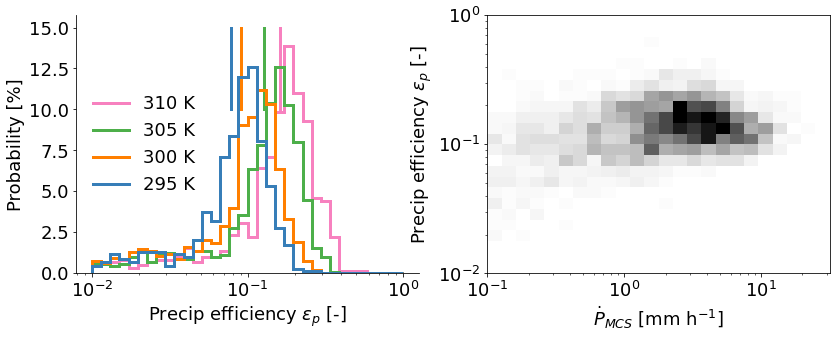

In [208]:
fs = 18
fig, ax = plt.subplots( 1, 2, figsize =(13.5, 4.75) )

for i, l in zip(peff_list, np.arange(len(peff_list)) ):
    #j = np.argwhere( (i > 10**(-3)) & (i < 1 ) )
    #i = i[j]
    print(len(i))
    wgts = np.ones_like( i )/float( len( i ) )*100
    ax[0].hist( i, bins=np.logspace(-2, 0, 35), histtype='step', weights=wgts, linewidth=3,
               edgecolor=CB_color_cycle[l] )
    ax[0].plot( [np.nanmedian(i), np.nanmedian(i)], [10, 15], linewidth=3, color=CB_color_cycle[l], label=sst[l] )
    
ax[0].set_ylabel( 'Probability [%]', fontsize=fs )
ax[0].set_xlabel( r'Precip efficiency $\varepsilon_p$ [-]', fontsize=fs )
ax[0].set_xscale( 'log' )
ax[0].set_xlim([-2,0])
ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)

handles, labels = ax[0].get_legend_handles_labels()
print(labels)
order = [0,1,2,3]
ax[0].legend( [handles[idx] for idx in order], [labels[idx] for idx in order], frameon=False, loc='center left' )

all_precip = np.concatenate( (mean_295['p_rate'], mean_300['p_rate'], mean_305['p_rate'],
                              mean_310['p_rate']) )#, mean_285['p_rate'], mean_290['p_rate']) )
all_precipeff = np.concatenate( (peff_list[0], peff_list[1], peff_list[2], peff_list[3]) )#, peff_list[4], peff_list[5]) )
ax[1].hist2d( all_precip, all_precipeff, bins=[ np.logspace(-1,1.5,25), np.logspace(-2,0,25) ], cmap=plt.cm.Greys )
ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].set_ylabel(r'Precip efficiency $\varepsilon_p$ [-]', fontsize=fs)
ax[1].set_xlabel(r'$\dot{P}_{MCS}$ [mm h$^{-1}$]', fontsize=fs)

fig.savefig( '/groups/sylvia/JAS-MCS-rain/figures/precipeff-RCE-AMS-poster.pdf', bbox_inches='tight' )
plt.show()

In [92]:
file = xr.open_dataset( '/xdisk/sylvia/ch_cam300ri0/ch_cam300ri0_4096x64x64_3km_12s_cam300ri0_64_0000086400.nc' )
display( file )

<xarray.Dataset>
Dimensions:  (x: 4096, y: 64, z: 64, time: 1)
Coordinates:
  * x        (x) float32 0.0 3e+03 6e+03 9e+03 ... 1.228e+07 1.228e+07 1.228e+07
  * y        (y) float32 0.0 3e+03 6e+03 9e+03 ... 1.83e+05 1.86e+05 1.89e+05
  * z        (z) float32 37.0 112.0 194.0 ... 2.696e+04 2.746e+04 2.796e+04
  * time     (time) float32 92.5
Data variables: (12/13)
    p        (z) float32 ...
    zi       (z) float32 ...
    U        (time, z, y, x) float32 ...
    V        (time, z, y, x) float32 ...
    W        (time, z, y, x) float32 ...
    PP       (time, z, y, x) float32 ...
    ...       ...
    TABS     (time, z, y, x) float32 ...
    QV       (time, z, y, x) float32 ...
    QN       (time, z, y, x) float32 ...
    QP       (time, z, y, x) float32 ...
    LQRAD    (time, z, y, x) float32 ...
    SQRAD    (time, z, y, x) float32 ...